# Модули

In [1]:
# import various packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import figure
from scipy.optimize import minimize
import pickle # нужно для записи данных при расчёте порохов
%config InlineBackend.figure_format = 'svg'
rc = {'font.family': 'serif',
      'font.serif': 'Times New Roman',
      'font.variant': 'normal',
      'font.weight':  'normal',
      'font.stretch': 'normal',
      'font.style': 'normal',
      'font.size':    14.0,
      'mathtext.default': 'regular',
      'mathtext.fontset': 'stix'}
plt.rcParams.update(rc)

# Исходные данные

In [2]:
# исходные данные для основного заряда
delta = 1603
omega = 818.161

D = 0.5856  # диаметр камеры сгорания
z_0 = 0.198  # e_0 для основного заряда
e_0 = z_0
n = 4
l_gr = 2.181
D_kr = 71.595*1e-3
F_kr = np.pi*(D_kr**2)/4
beta = np.pi/n

c_ = 0.05
d = D - 2 * z_0
d_ = d / D
a_ = 0.3
a = a_ * l_gr
c = c_ * D


# Исходные данные
p_ref_t = 1e6
p_h = 1e5
p_nom_0 = 16.593*1e6

T_m50 = 273.15 - 50  # -50
T_20 = 293.15  # 20
T_50 = 273.15 + 50  # 50
T_s = 750
T_ref = T_20
T_0 = T_m50

c_p_nach = 1004.5
R_nach = 287

#igniter
p_ref_B = 98066.5
rho_B = 1750
u_1_B = 11.7*1e-3
nu_B = 0.226
D_t_B = 0.001

#terra
T_p_0 = 1984.1 
mu_g = 0.6130*1e-4
lamda_g = 0.11938
c_p_0 = 1224.6
z_0_Bospl = 0.4119  # конденсированная фаза при горении вопсламенителя - из Терры
R_Bospl = 228.08  # газовая постоянная продуктов сгорания воспламенителя - из Терры
R_0 = R_Bospl*(1-z_0_Bospl)

#TRT
z_0_Topl = 0.3239  # конденсированная фаза при горении основного заряда - из Терры
R_Topl = 550.84  # газовая постоянная продуктов сгорания основного заряда - из Терры
R_1 = R_Topl*(1-z_0_Topl)

T_p_1 = 2999.5
n_t = 1.1755  # показатель политропы топлива
n_kr = 1.1604
# параметры закона горения
u_1_t = 4.38*1e-3
nu_t = 0.29
D_t_t = 0.002
c_p_1 = 2236.7
c_t, lamda_t, rho_t = 1250, 0.3, delta
kappa_ref = 100



# предварительные вычисления
A_n = (n_kr*(2/(n_kr+1))**((n_kr+1)/(n_kr-1)))**0.5
S_g_sr = omega/(rho_t*e_0)
F_sv = np.pi*d**2/4
F_sv = np.pi*d**2/4
z_1 = 0.5*(d*np.sin(beta)-c)/(1-np.sin(beta))
z_2 = (D*np.sin(beta)-c)/2
# перерасчёт номинального давления в зависимости от начальной температуры и параметра Победоносцева
p_nom = p_nom_0*np.exp((D_t_t*(T_0-T_ref))/(1-nu_t))
# Начальные условия
W_0 = np.pi*D**3/12+np.pi*D**2/4*l_gr-omega/rho_t
etta_T_s = (T_s-T_0)**2

# Функции

In [3]:
def S_g_B(e, e_B_0):
    global W
    e0 = e_B_0
    d = e_B_0*5
    #d = 0.21 * 1e-3
    c = e_B_0*0.8
    h = e0 - c/2

    def R(d, h, e0):
        r = d/2
        return (r**2 + h**2)/2/h

    def S1(e, e0):
        r = d/2
        return 4*np.pi*(R(d, h, e0)-e)*h1(e, e0) + 2*np.pi*(r - e)*c1(e, e0)

    def h1(e, e0):
        r = d/2
        return (R(d, h, e0) - e) - np.sqrt((R(d, h, e0) - e)**2 - (r - e)**2)

    def c1(e, e0):
        return 2*(e0 - e - h1(e, e0))

    def S2(e, e0):
        return 4*np.pi*(R(d, h, e0) - e)*(e0 - e)

    def e1(e, e0):
        r = d/2
        return ((R(d, h, e0)**2 - r**2) - (R(d, h, e0) - e0)**2)/(2*(R(d, h, e0) - r))
    ee = e1(e, e0)

    def WW(e, e0):
        r = d/2
        return np.pi*r**2*c + 2*np.pi*h**2*(R(d, h, e0) - h/3)
    W = WW(e, e0)
    if e < ee:
        return S1(e, e0)
    else:
        return S2(e, e0)


def X(G_B, T, G_t, dQ_t_dt, F_q_1_):
    x = G_B*c_p_0*(T_p_0-T)+G_t*c_p_1*(T_p_1-T)-dQ_t_dt*F_q_1_  # c_p_1
    return x


def Y(G_B, T, G_t, p, rho, G):
    y = G_B*R_0*T+G_t*R_1*T-p/rho*G-p*(G_B/rho_B + G_t/rho_t)
    return y

# закон горения


def U_t(p):
    return u_1_t*(p/p_ref_t)**nu_t*np.exp(D_t_t*(T_0-T_ref))


def U_B(p):
    return u_1_B*(p/p_ref_B)**nu_B*np.exp(D_t_B*(T_0-T_ref))


def FI_kappa(kappa):  # check
    return 1


def Kappa(S_g_0, F_sv):  # параметр Победоносцева  #check
    return S_g_0/F_sv




def F_q_1(etta_t):

    if etta_t < etta_T_s:
        return 1
    else:
        return 0


def F_0(e):
    if e <= e_B_0:
        return 1
    else:
        return 0


def F_1(etta_T, e):
    if etta_T >= etta_T_s and e <= e_0:
        return 1
    else:
        return 0

# расчёт теплового потока


def q(etta_T, G_B, T):
    Pr = (c_p_0*mu_g)/lamda_g
    rho_v = G_B/F_sv
    Re = (rho_v*d)/mu_g
    Nu = 0.023*Re**0.8*Pr*0.4
    alpha = Nu*lamda_g/d
    return alpha*(T-(T_0+etta_T**0.5))


def Pi(lamda, k):
    return (1 - (k-1)/(k+1)*lamda**2)**(k/(k-1))


def G_(p, R, T, k):  # секундный массовый расход ПС через сопло
    if p*Pi(1, k) < p_h:

        return ((p*F_kr)/(np.sqrt(R*T)))*(p_h/p)**(1/n)*np.sqrt(2*n/(n-1)*np.abs(1-(p_h/p)**((n-1)/n)))
    else:
        return (A_n*F_kr*p)/((R*T)**0.5)


def G_b(S, u, F_0):  # расход от воспламенителя
    return S*u*rho_B*F_0


def G_topl(S, u, fi_kappa, f_1):  # расход от основного заряда
    return S*u*rho_t*f_1*fi_kappa


def S_g_t(z):  # зависимость площади поверхности горения основного заряда
    def e_1(d, beta, c):
        return 0.5*((d*np.sin(beta) - c)/(1 - np.sin(beta)))

    def e_2(D, beta, c):
        return 0.5*(D*np.sin(beta) - c)

    def S_a(z):
        if np.pi*(d + 2*z)*(l_gr - a - z):
            return np.pi*(d + 2*z)*(l_gr - a - z)
        else:
            return 0

    def S_b(z):
        if z > z_1:
            return 0
        else:
            return n*(beta - fi_1(z))*(d + 2*z)*a

    def fi_1(z):
        return np.arcsin((c + 2*z)/(d + 2*z))

    def S_c(z):
        if z >= 0 and z <= z_1:
            return 2*n*a*b1(z)
        elif z_1 < z and z <= z_2:
            return 2*n*a*b2(z)
        elif z > z_2:
            return 0
        else:
            return 0  # ???

    def b1(z):
        return 0.5*(np.sqrt(D**2 - (c + 2*z)**2) - np.sqrt((d + 2*z)**2 - (c + 2*z)**2))

    def b2(z):
        return 0.5*(np.sqrt(D**2 - (c + z*2)**2) - (c + 2*z)*np.tan(beta)**(-1))

    def S_d(z):
        if np.pi/4*(D**2 - (d + 2*z)**2):
            return np.pi/4*(D**2 - (d + 2*z)**2)
        else:
            return 0

    def S(z):
        return S_a(z) + S_b(z) + S_c(z) + S_d(z)

    e1 = e_1(d, beta, c)
    e2 = e_2(D, beta, c)

    return S(z)


def rk4(init, sys, t0, dt, n, stop=0):

    # declaration

    t = np.zeros(n)
    m = len(init) + 1
    res = np.zeros((n, m))

    # initialization

    i = 0
    X = init
    t[i] = t0
    res[i, 0] = t[i]
    res[i, 1:m] = X

    # main loop
    # while stop(t[i], X) > 0 and i < n - 1:
    if stop == 0:
        while i < n - 1:
            k1 = sys(t[i], X)
            k2 = sys(t[i] + 0.5*dt, X + k1*0.5*dt)
            k3 = sys(t[i] + 0.5*dt, X + k2*0.5*dt)
            k4 = sys(t[i] + dt, X + k3*dt)
            i += 1
            X += (k1 + 2*k2 + 2*k3 + k4)*dt/6
            t[i] = t[i - 1] + dt
            res[i, 0] = t[i]
            res[i, 1:m] = X
    else:
        k = X[3]/(X[3]-X[4])
        while X[0] > p_h/Pi(1, k) and i < n - 1:
            k1 = sys(t[i], X)
            k2 = sys(t[i] + 0.5*dt, X + k1*0.5*dt)
            k3 = sys(t[i] + 0.5*dt, X + k2*0.5*dt)
            k4 = sys(t[i] + dt, X + k3*dt)
            i += 1
            X += (k1 + 2*k2 + 2*k3 + k4)*dt/6
            t[i] = t[i - 1] + dt
            res[i, 0] = t[i]
            res[i, 1:m] = X

    return res[0:i + 1, :]


def System(t, y):
    p, T, W, c_p, R, e_B, e, etta_T = y
    k = c_p/(c_p-R)
    rho = p/(R*T)
    f_q_1 = F_q_1(etta_T)
    f_0 = F_0(e_B)
    f_1 = F_1(etta_T, e)
    S_0 = S_g_t(0)

    u_B = U_B(p)
    u = U_t(p)
    S_B = N*S_g_B(e_B, e_B_0)
    S_t = S_g_t(e)
    d_kan_ = d+2*e
    F_kan = np.pi*d_kan_**2/4
    kappa = Kappa(S_t, F_kan)
    fi_kappa = FI_kappa(kappa)

    G_B = G_b(N*S_g_B(e_B, e_B_0), u_B, f_0)
    G_t = G_topl(S_g_t(e), u, fi_kappa, f_1)
    G = G_(p, R, T, k)

    q_1 = q(etta_T, G_B, T)
    dQ_t_dt = q_1*S_0

    x = X(G_B, T, G_t, dQ_t_dt, f_q_1)
    y_ = Y(G_B, T, G_t, p, rho, G)

    dp_dt = (k-1)/W*(x+y_*k/(k-1))
    dT_dt = (k - 1)/(rho*W*R)*(x+y_)  # 1/
    dW_dt = G_B/rho_B+G_t/rho_t
    dc_p_dt = 1/(rho*W)*(G_B*(c_p_0-c_p)+G_t*(c_p_1-c_p))
    dR_dt = 1/(rho*W)*(G_B*(R_0-R)+G_t*(R_1-R))
    de_b_dt = u_B*f_0
    de_dt = u*fi_kappa*f_1
    detta_T_dt = (2*q_1**2)/(c_t*lamda_t*rho_t)*f_q_1

    return np.array([dp_dt, dT_dt, dW_dt, dc_p_dt, dR_dt, de_b_dt, de_dt, detta_T_dt])


def conjugate_gradient(x0, f, met='nelder-mead'):
    #met = ['Nelder-Mead', 'Powell', 'CG', 'Newton-CG',  'BFGS','L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov']
    all_x_i = [x0[0]]
    all_y_i = [x0[1]]
    all_f_i = [f(x0)]

    def store(X):
        x, y = X
        all_x_i.append(x)
        all_y_i.append(y)
        all_f_i.append(f(X))
    minimize(f, x0, method=met, callback=store)
    return all_x_i, all_y_i


def calc(x, minimize_finished=0): # 0 для минимизации, после меняется на 1

    if minimize_finished == 0:
        global e_B_0, N
        N = x[0]
        e_B_0 = x[1]
    else:
        N = x[0]
        e_B_0 = x[1]

    # предварительные вычисления
    A_n = (n_kr*(2/(n_kr+1))**((n_kr+1)/(n_kr-1)))**0.5
    S_g_sr = omega/(rho_t*e_0)
    F_sv = np.pi*d**2/4

    F_kr = (S_g_sr*U_t(p_nom)*rho_t*(R_1*T_p_1)**0.5)/(A_n*p_nom)

    etta_T_s = (T_s-T_0)**2

    # горение основного заряда
    beta = np.pi/n
    F = np.pi*(D**2)/4
    c_ = c/D
    d_ = d/D
    a_ = 0.3
    epsilon_f = 1 - d_**2
    f_cut = (n/np.pi) * (c_*np.sqrt(1 - c_**2) - c_*np.sqrt(d_ **
                                                            2 - c_**2) + np.arcsin(c_) - d_**2 * np.arcsin(c_/d_))
    epsilon_w = epsilon_f - a_*f_cut
    F_cut = F*f_cut
    z_1 = 0.5*(d*np.sin(beta)-c)/(1-np.sin(beta))
    z_2 = (D*np.sin(beta)-c)/2
    # длина заряда
    l_gr = omega/(delta * epsilon_w * F)

    # сначала интегрируем до
    t_k_1 = 0.25
    # с шагом
    d_t_1 = 5*1e-5
    # Начальные условия
    W_0 = np.pi*D**3/12+np.pi*D**2/4*l_gr-omega/rho_t
    INIT_1 = np.array([1e5, T_0, W_0, c_p_nach, R_nach, 0, 0, 0])

    Res = rk4(INIT_1, System, 0, d_t_1, int(t_k_1/d_t_1))

    e_topl = Res[:, 7]
    p_kam = Res[:, 1]
    e_vospl = Res[:, 6]
    t_kam = Res[:, 0]
    ind = 0
    for i in range(len(e_topl)):
        if e_topl[i] != 0:
            ind = i
            break
    p_kam[ind]
    p_nom_2 = sum(p_kam[ind:])/len(p_kam[ind:])
    W_sgor_v = 0

    for i in range(ind-1):
        dW = S_g_B(e_vospl[i], e_B_0)*(e_vospl[i+1]-e_vospl[i])
        W_sgor_v += dW
    if minimize_finished == 0:
        if e_topl[len(e_topl)//3] > 0:
            if e_B_0 < 0:
                return max(p_kam)*10000
            if W_sgor_v/W > 0.8:
                return max(p_kam)*10000
            else:
                return max(p_kam)/p_nom_2
        else:
            return max(p_kam)*10000
    else:
        if e_topl[len(e_topl)//3] > 0:
            if e_B_0 < 0 or W_sgor_v/W > 0.9:
                return [[0, max(p_kam)*100], max(p_kam)*100, max(p_kam)*100]
            else:
                mass_otnos = W_sgor_v/W
                t_sgor = t_kam[ind]
                return [[1, max(p_kam)/p_nom_2], mass_otnos, t_sgor]
        else:
            return [[0, max(p_kam)*100], max(p_kam)*100, max(p_kam)*100]
    # print(len(T_kam),len(t_kam))


def f_res(INIT, t_k_0, t_k_1, d_t, f=0):
    Res = rk4(INIT, System, t_k_0, d_t, int(t_k_1/d_t), stop=f)
    e_topl = Res[:, 7]
    p_kam = Res[:, 1]
    e_vospl = Res[:, 6]
    t_kam = Res[:, 0]
    T_kam = Res[:, 2]
    return [Res, {'e_topl': e_topl, 'p_kam': p_kam, 'e_vospl': e_vospl, 't_kam': t_kam, 'T_kam': T_kam}]


def create_net(N_opt, e_B_0_opt):
    res, NN, e_BB, NN1, e_BB1, p_p_nom = [], [], [], [], [], []
    p_p_min, NN_min, e_BB_min = 100, 0, 0
    k = 0
    cr_1 = []
    z, xx, yy, xx1, yy1 = [], [], [], [], []
    mass_otn = []
    t_sgor = []
    for i in range(0, 10, 1):
        N = N_opt - 1000 + 200*i
        for j in range(0, 10, 1):
            e_B_0 = e_B_0_opt - 0.00036 + 0.00009*j
            solve_f = calc([N, e_B_0], minimize_finished=1)
            cr_1.append(solve_f[0])
        #         print(cr_1)
            if cr_1[k][0] != 0:
                NN.append(N)
                e_BB.append(e_B_0)
                p_p_nom.append(cr_1[k][1])
                mass_otn.append(solve_f[1])
                t_sgor.append(solve_f[2])
            else:
                NN1.append(N)
                e_BB1.append(e_B_0)
            k += 1
    return [NN, e_BB, NN1, e_BB1, p_p_nom, mass_otn, t_sgor]

# Решение

## Предварительные вычисления

## Построение сетки вокруг оптимальных параметров

In [4]:
# # Выполняется построение сетки (около 7 минут)
# N_opt, e_B_0_opt = 10000, 0.002 # для +50 оставить тоже самое
# Res = create_net(N_opt, e_B_0_opt) # для +50 T_0 = T_50 в исх.данных
# FILENAME = f"opt_2.bin"
# with open(FILENAME, 'wb') as f:
#     pickle.dump(Res, f)

1.1164638517748315
10800
0.00191
0.6963332011390978
0.038750000000000596


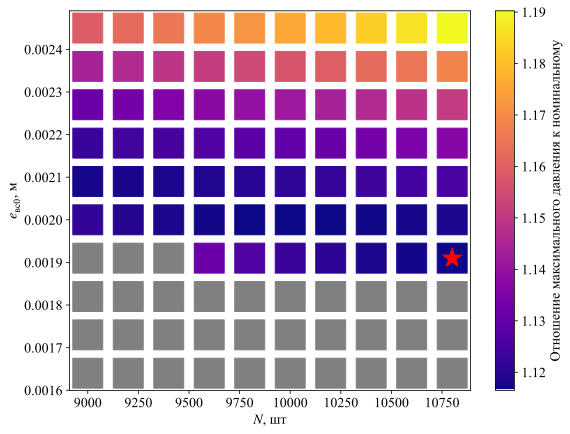

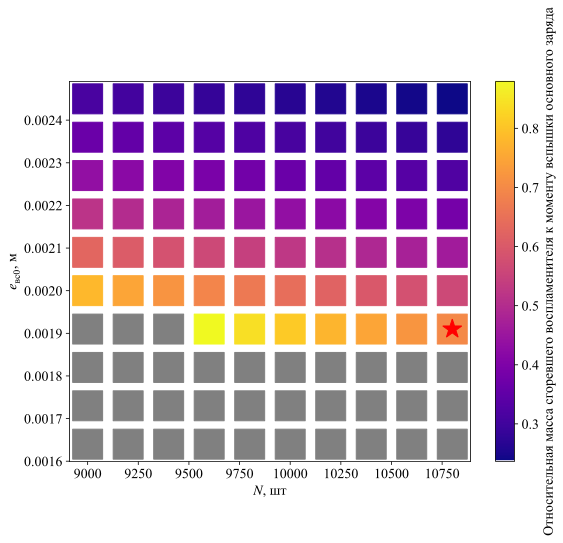

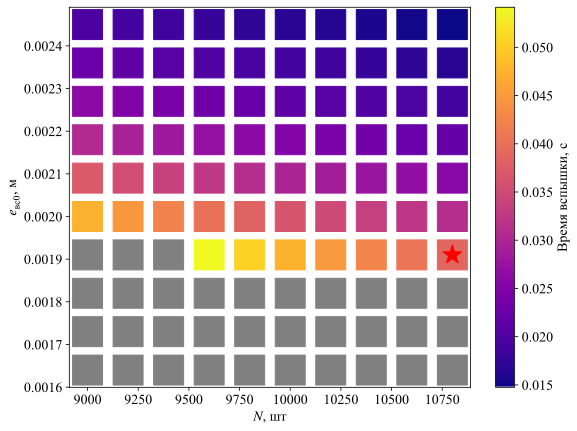

In [6]:
FILENAME = f"opt_2.bin"
with open(FILENAME, 'rb') as f:
    NN, e_BB, NN1, e_BB1, p_p_nom, mass_otn, t_sgor = pickle.load(f)
# NN, e_BB, NN1, e_BB1, p_p_nom, mass_otn, t_sgor = Res
p_p_min = min(p_p_nom)
ind_min = list(p_p_nom).index(p_p_min)
NN_min = NN[ind_min]
e_BB_min = e_BB[ind_min]
# NN_min = 12000
# e_BB_min = 0.00245
print(p_p_min)
print(NN_min)
print(e_BB_min)
print(mass_otn[ind_min])
print(t_sgor[ind_min])
fig = plt.figure(figsize=[9, 7])

fig.patch.set_facecolor('white')
plt.scatter(NN, e_BB, c=p_p_nom, s=900, marker='s', cmap='plasma')
plt.colorbar(label='Отношение максимального давления к номинальному')
plt.scatter(NN1, e_BB1, color='grey', s=900, marker='s')
plt.plot(NN_min, e_BB_min, color='r',marker='*', markersize=20)
plt.xlabel('$\mathit{N}$, шт')
plt.ylabel('$\mathit{e}_{вc 0}$, м')
# plt.savefig(f'1.png',dpi=300, bbox_inches='tight')
plt.plot()
plt.show()

fig = plt.figure(figsize=[9, 7])
fig.patch.set_facecolor('white')
plt.scatter(NN, e_BB, c=mass_otn, s=900, marker='s', cmap='plasma')
plt.colorbar(label='Относительная масса сгоревшего воспламенителя к моменту вспышки основного заряда')
plt.scatter(NN1, e_BB1, color='grey', s=900, marker='s')

plt.xlabel('$\mathit{N}$, шт')
plt.ylabel('$\mathit{e}_{вc 0}$, м')
plt.plot(NN_min, e_BB_min, color='r',marker='*', markersize=20)
# plt.savefig(f'2.png',dpi=300, bbox_inches='tight')
plt.plot()
plt.show()

fig = plt.figure(figsize=[9, 7])
fig.patch.set_facecolor('white')
plt.scatter(NN, e_BB, c=t_sgor, s=900, marker='s', cmap='plasma')
plt.colorbar(label='Время вспышки, с')
plt.scatter(NN1, e_BB1, color='grey', s=900, marker='s')
plt.plot(NN_min, e_BB_min, color='r',marker='*', markersize=20)
plt.xlabel('$\mathit{N}$, шт')
plt.ylabel('$\mathit{e}_{вc 0}$, м')
# plt.savefig(f'3.png',dpi=300, bbox_inches='tight')
plt.plot()
plt.show()
#plt.title('Methods: trust-constr, SLSQP')
# plt.grid()

## Построение графиков для 1 этапа

1 этап: ($\mathit{t}$ = 0...0,25 с) 

In [7]:
N, e_B_0 = NN_min, e_BB_min
# сначала интегрируем до
t_k_1 = 0.25
# с шагом
d_t_1 = 5*1e-5

INIT_1_1 = np.array([1e5, T_0, W_0, c_p_nach, R_nach, 0, 0, 0])
res_1_1 = f_res(INIT_1_1, 0, t_k_1, d_t_1)
# FILENAME = f"res_1_1.bin"
# with open(FILENAME, 'wb') as f:
#     pickle.dump(res_1_1, f)
# INIT_1_2 = np.array([1e5, T_20, W_0, c_p_nach, R_nach, 0, 0, 0])
# res_1_2 = f_res(INIT_1_2, 0, t_k_1, d_t_1)
# FILENAME = f"res_1_2.bin"
# with open(FILENAME, 'wb') as f:
#     pickle.dump(res_1_2, f)
# INIT_1_3 = np.array([1e5, T_50, W_0, c_p_nach, R_nach, 0, 0, 0])
# res_1_3 = f_res(INIT_1_3, 0, t_k_1, d_t_1)
# FILENAME = f"res_1_3.bin"
# with open(FILENAME, 'wb') as f:
#     pickle.dump(res_1_3, f)





In [8]:
# FILENAME = f"res_1_1.bin"
# with open(FILENAME, 'rb') as f:
#     res_1_1 = pickle.load(f)
FILENAME = f"res_1_2.bin"
with open(FILENAME, 'rb') as f:
    res_1_2 = pickle.load(f)
FILENAME = f"res_1_3.bin"
with open(FILENAME, 'rb') as f:
    res_1_3 = pickle.load(f)
ind = 0
for i in range(len(res_1_1[1]['e_topl'])):
    if res_1_1[1]['e_topl'][i] != 0:
        ind = i
        break
p_nom_1 = sum(res_1_1[1]['p_kam'][ind:])/len(res_1_1[1]['p_kam'][ind:])
print(p_nom_1)
print(max(res_1_1[1]['p_kam'])/p_nom_1, N, e_B_0)


13641610.888356715
1.1166144374973648 10800 0.00191


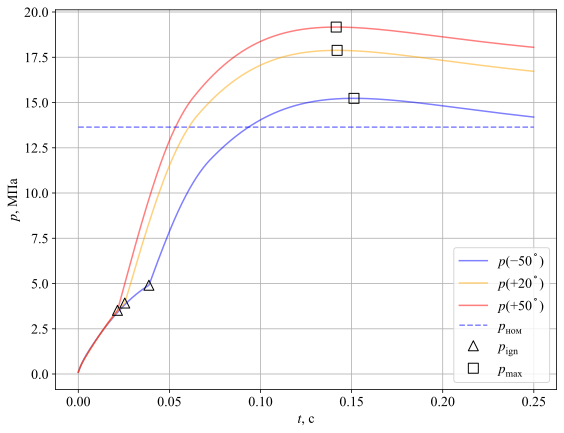

In [9]:
fig = plt.figure(figsize=[9, 7])
fig.patch.set_facecolor('white')
plt.plot(res_1_1[1]['t_kam'][:-1], res_1_1[1]['p_kam'][:-1]/1e6,
         color='b', label='$\mathit{p}(-50^\circ)$', alpha=0.5)
plt.plot(res_1_2[1]['t_kam'][:-1], res_1_2[1]['p_kam'][:-1]/1e6,
         color='orange', label='$\mathit{p}(+20^\circ)$', alpha=0.5)
plt.plot(res_1_3[1]['t_kam'][:-1], res_1_3[1]['p_kam'][:-1]/1e6,
         color='r', label='$\mathit{p}(+50^\circ)$', alpha=0.5)
plt.plot([0, 0.25], [p_nom_1/1e6, p_nom_1/1e6],
         color='b', label='$\mathit{p}_{ном}$', ls='--', alpha=0.5)

# Конец горения воспламенителя
p_m50_1 = res_1_1[1]['p_kam'][res_1_1[1]['e_topl']==0][-1]
p_20_1 = res_1_2[1]['p_kam'][res_1_2[1]['e_topl']==0][-1]
p_50_1 = res_1_3[1]['p_kam'][res_1_3[1]['e_topl']==0][-1]
t_m50_1 = res_1_1[1]['t_kam'][res_1_1[1]['e_topl']==0][-1]
t_20_1 = res_1_2[1]['t_kam'][res_1_2[1]['e_topl']==0][-1]
t_50_1 = res_1_3[1]['t_kam'][res_1_3[1]['e_topl']==0][-1]
T_m50_1 = res_1_1[1]['T_kam'][res_1_1[1]['e_topl']==0][-1]
T_20_1 = res_1_2[1]['T_kam'][res_1_2[1]['e_topl']==0][-1]
T_50_1 = res_1_3[1]['T_kam'][res_1_3[1]['e_topl']==0][-1]
p_1 = np.array([p_m50_1, p_20_1, p_50_1])
t_1 = np.array([t_m50_1, t_20_1, t_50_1])
plt.plot(t_1, p_1/1e6, marker='^', markersize=10, linestyle='None',
         color='none',markeredgecolor='black', label='$\mathit{p}_{ign}$')

# Максимальное значение давления
p_m50_2 = res_1_1[1]['p_kam'][res_1_1[1]['p_kam']==max(res_1_1[1]['p_kam'])][-1]
p_20_2 = res_1_2[1]['p_kam'][res_1_2[1]['p_kam']==max(res_1_2[1]['p_kam'])][-1]
p_50_2 = res_1_3[1]['p_kam'][res_1_3[1]['p_kam']==max(res_1_3[1]['p_kam'])][-1]
t_m50_2 = res_1_1[1]['t_kam'][res_1_1[1]['p_kam']==max(res_1_1[1]['p_kam'])][-1]
t_20_2 = res_1_2[1]['t_kam'][res_1_2[1]['p_kam']==max(res_1_2[1]['p_kam'])][-1]
t_50_2 = res_1_3[1]['t_kam'][res_1_3[1]['p_kam']==max(res_1_3[1]['p_kam'])][-1]
T_m50_2 = res_1_1[1]['T_kam'][res_1_1[1]['p_kam']==max(res_1_1[1]['p_kam'])][-1]
T_20_2 = res_1_2[1]['T_kam'][res_1_2[1]['p_kam']==max(res_1_2[1]['p_kam'])][-1]
T_50_2 = res_1_3[1]['T_kam'][res_1_3[1]['p_kam']==max(res_1_3[1]['p_kam'])][-1]
p_2 = np.array([p_m50_2, p_20_2, p_50_2])
t_2 = np.array([t_m50_2, t_20_2, t_50_2])
plt.plot(t_2, p_2/1e6, marker='s', markersize=10, linestyle='None',
         color='none',markeredgecolor='black', label='$\mathit{p}_{max}$')

plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{p}$, МПа')
plt.legend()
plt.grid()
# plt.savefig(f'4.png',dpi=300, bbox_inches='tight')
plt.show()


## Построение графиков для 2 этапа

2 этап: интегрируется, пока давление не упадёт до критического.

In [9]:
# сначала интегрируем до
t_k_2 = 120 # задаётся произвольно
# с шагом
d_t_2 = 5*1e-3
# начальными условиями являются резул 

# результаты для первого этапа
# INIT_2_1 = res_1_1[0][-1][1:]
# res_2_1 = f_res(INIT_2_1, t_k_1, t_k_2, d_t_2, f = 1)
# FILENAME = f"res_2_1.bin"
# with open(FILENAME, 'wb') as f:
#     pickle.dump(res_2_1, f)
# начальными условиями являются результаты для первого этапа
INIT_2_2 = res_1_2[0][-1][1:]
res_2_2 = f_res(INIT_2_2, t_k_1, t_k_2, d_t_2)
# FILENAME = f"res_2_2.bin"
# with open(FILENAME, 'wb') as f:
#     pickle.dump(res_2_2, f)
# начальными условиями являются результаты для первого этапа
# INIT_2_3 = res_1_3[0][-1][1:]
# res_2_3 = f_res(INIT_2_3, t_k_1, t_k_2, d_t_2)
# FILENAME = f"res_2_3.bin"
# with open(FILENAME, 'wb') as f:
#     pickle.dump(res_2_3, f)

<ipython-input-3-1934ecffd53f>:59: RuntimeWarning: invalid value encountered in double_scalars
  return u_1_B*(p/p_ref_B)**nu_B*np.exp(D_t_B*(T_0-T_ref))
<ipython-input-3-1934ecffd53f>:55: RuntimeWarning: invalid value encountered in double_scalars
  return u_1_t*(p/p_ref_t)**nu_t*np.exp(D_t_t*(T_0-T_ref))
<ipython-input-3-1934ecffd53f>:112: RuntimeWarning: invalid value encountered in double_scalars
  return ((p*F_kr)/(np.sqrt(R*T)))*(p_h/p)**(1/n)*np.sqrt(2*n/(n-1)*np.abs(1-(p_h/p)**((n-1)/n)))


In [10]:
FILENAME = f"res_2_1.bin"
with open(FILENAME, 'rb') as f:
    res_2_1 = pickle.load(f)
# FILENAME = f"res_2_2.bin"
# with open(FILENAME, 'rb') as f:
#     res_2_2 = pickle.load(f)
FILENAME = f"res_2_3.bin"
with open(FILENAME, 'rb') as f:
    res_2_3 = pickle.load(f)

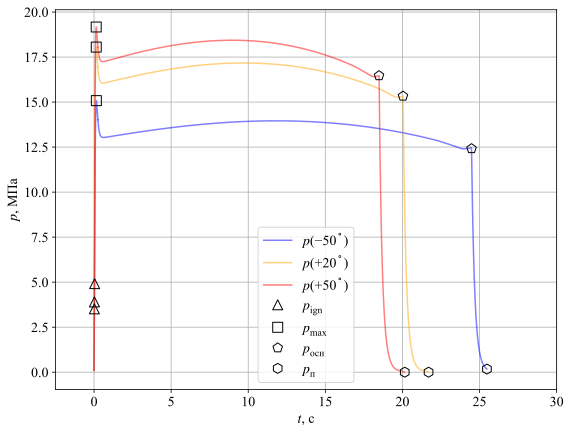

In [11]:
fig = plt.figure(figsize=[9, 7])
fig.patch.set_facecolor('white')
plt.plot(res_1_1[1]['t_kam'][:-1], res_1_1[1]['p_kam'][:-1]/1e6,
         color='b', label='$\mathit{p}(-50^\circ)$', alpha=0.5)
plt.plot(res_2_1[1]['t_kam'][:-1], res_2_1[1]['p_kam'][:-1]/1e6,
         color='b', alpha=0.5)
plt.plot(res_1_2[1]['t_kam'][:-1], res_1_2[1]['p_kam'][:-1]/1e6,
         color='orange', label='$\mathit{p}(+20^\circ)$', alpha=0.5)
plt.plot(res_2_2[1]['t_kam'][:-1], res_2_2[1]['p_kam'][:-1]/1e6,
         color='orange', alpha=0.5)
plt.plot(res_1_3[1]['t_kam'][:-1], res_1_3[1]['p_kam'][:-1]/1e6,
         color='r', label='$\mathit{p}(+50^\circ)$', alpha=0.5)
plt.plot(res_2_3[1]['t_kam'][:-1], res_2_3[1]['p_kam'][:-1]/1e6,
         color='r', alpha=0.5)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{p}$, МПа')

# Конец горения воспламенителя
p_m50_1 = res_1_1[1]['p_kam'][res_1_1[1]['e_topl']==0][-1]
p_20_1 = res_1_2[1]['p_kam'][res_1_2[1]['e_topl']==0][-1]
p_50_1 = res_1_3[1]['p_kam'][res_1_3[1]['e_topl']==0][-1]
t_m50_1 = res_1_1[1]['t_kam'][res_1_1[1]['e_topl']==0][-1]
t_20_1 = res_1_2[1]['t_kam'][res_1_2[1]['e_topl']==0][-1]
t_50_1 = res_1_3[1]['t_kam'][res_1_3[1]['e_topl']==0][-1]
T_m50_1 = res_1_1[1]['T_kam'][res_1_1[1]['e_topl']==0][-1]
T_20_1 = res_1_2[1]['T_kam'][res_1_2[1]['e_topl']==0][-1]
T_50_1 = res_1_3[1]['T_kam'][res_1_3[1]['e_topl']==0][-1]
p_1 = np.array([p_m50_1, p_20_1, p_50_1])
t_1 = np.array([t_m50_1, t_20_1, t_50_1])
plt.plot(t_1, p_1/1e6, marker='^', markersize=10, linestyle='None',
         color='none',markeredgecolor='black', label='$\mathit{p}_{ign}$')

# Максимальное значение давления
p_m50_2 = res_1_1[1]['p_kam'][res_1_1[1]['p_kam']==max(res_1_1[1]['p_kam'])][-1]
p_20_2 = res_1_2[1]['p_kam'][res_1_2[1]['p_kam']==max(res_1_2[1]['p_kam'])][-1]
p_50_2 = res_1_3[1]['p_kam'][res_1_3[1]['p_kam']==max(res_1_3[1]['p_kam'])][-1]
t_m50_2 = res_1_1[1]['t_kam'][res_1_1[1]['p_kam']==max(res_1_1[1]['p_kam'])][-1]
t_20_2 = res_1_2[1]['t_kam'][res_1_2[1]['p_kam']==max(res_1_2[1]['p_kam'])][-1]
t_50_2 = res_1_3[1]['t_kam'][res_1_3[1]['p_kam']==max(res_1_3[1]['p_kam'])][-1]
T_m50_2 = res_1_1[1]['T_kam'][res_1_1[1]['p_kam']==max(res_1_1[1]['p_kam'])][-1]
T_20_2 = res_1_2[1]['T_kam'][res_1_2[1]['p_kam']==max(res_1_2[1]['p_kam'])][-1]
T_50_2 = res_1_3[1]['T_kam'][res_1_3[1]['p_kam']==max(res_1_3[1]['p_kam'])][-1]
p_2 = np.array([p_m50_2, p_20_2, p_50_2])
t_2 = np.array([t_m50_2, t_20_2, t_50_2])
plt.plot(t_2, p_2/1e6, marker='s', markersize=10, linestyle='None',
         color='none',markeredgecolor='black', label='$\mathit{p}_{max}$')


# Конец горения основного заряда
p_m50_3 = res_2_1[1]['p_kam'][res_2_1[1]['e_topl']<=e_0][-1]
p_20_3 = res_2_2[1]['p_kam'][res_2_2[1]['e_topl']<=e_0][-1]
p_50_3 = res_2_3[1]['p_kam'][res_2_3[1]['e_topl']<=e_0][-1]
t_m50_3 = res_2_1[1]['t_kam'][res_2_1[1]['e_topl']<=e_0][-1]
t_20_3 = res_2_2[1]['t_kam'][res_2_2[1]['e_topl']<=e_0][-1]
t_50_3 = res_2_3[1]['t_kam'][res_2_3[1]['e_topl']<=e_0][-1]
T_m50_3 = res_2_1[1]['T_kam'][res_2_1[1]['e_topl']<=e_0][-1]
T_20_3 = res_2_2[1]['T_kam'][res_2_2[1]['e_topl']<=e_0][-1]
T_50_3 = res_2_3[1]['T_kam'][res_2_3[1]['e_topl']<=e_0][-1]
p_3 = np.array([p_m50_3, p_20_3, p_50_3])
t_3 = np.array([t_m50_3, t_20_3, t_50_3])
plt.plot(t_3, p_3/1e6, marker='p', markersize=10, linestyle='None',
         color='none',markeredgecolor='black', label='$\mathit{p}_{осн}$')


# Конец интегрирования
p_m50_4 = res_2_1[1]['p_kam'][res_2_1[1]['e_topl']>=e_0][-1]
p_20_4 = res_2_2[1]['p_kam'][res_2_2[1]['e_topl']>=e_0][-1]
p_50_4 = res_2_3[1]['p_kam'][res_2_3[1]['e_topl']>=e_0][-1]
t_m50_4 = res_2_1[1]['t_kam'][res_2_1[1]['e_topl']>=e_0][-1]
t_20_4 = res_2_2[1]['t_kam'][res_2_2[1]['e_topl']>=e_0][-1]
t_50_4 = res_2_3[1]['t_kam'][res_2_3[1]['e_topl']>=e_0][-1]
T_m50_4 = res_2_1[1]['T_kam'][res_2_1[1]['e_topl']>=e_0][-1]
T_20_4 = res_2_2[1]['T_kam'][res_2_2[1]['e_topl']>=e_0][-1]
T_50_4 = res_2_3[1]['T_kam'][res_2_3[1]['e_topl']>=e_0][-1]
p_4 = np.array([p_m50_4, p_20_4, p_50_4])
t_4 = np.array([t_m50_4, t_20_4, t_50_4])
plt.plot(t_4, p_4/1e6, marker='h', markersize=10, linestyle='None',
         color='none',markeredgecolor='black', label='$\mathit{p}_{п}$')


plt.legend()
plt.grid()
plt.xlim(-2.5, 30)
# plt.savefig(f'6.png',dpi=300, bbox_inches='tight')
plt.show()

In [13]:
data_4 = [np.array([np.round(t_m50_1, 3), np.round(t_m50_2, 3), np.round(t_m50_3, 3), np.round(t_m50_4, 3)]), np.array([
    np.round(p_m50_1/1e6, 3), np.round(p_m50_2/1e6, 3), np.round(p_m50_3/1e6, 3), np.round(p_m50_4/1e6, 3)]), np.array([np.round(T_m50_1, 3), np.round(T_m50_2, 3), np.round(T_m50_3, 3), np.round(T_m50_4, 3)])]

data_4_show = pd.DataFrame(data_4, index=["t, с", "p, МПа", "T, К"], columns=[
    i for i in range(1, 4+1)]).T
# pd.set_option('display.float_format', '{:.5}'.format)
display(data_4_show)

data_4_show.to_excel('data_4.xlsx')


data_5 = [np.array([np.round(t_20_1, 3), np.round(t_20_2, 3), np.round(t_20_3, 3), np.round(t_20_4, 3)]), np.array([
    np.round(p_20_1/1e6, 3), np.round(p_20_2/1e6, 3), np.round(p_20_3/1e6, 3), np.round(p_20_4/1e6, 3)]), np.array([np.round(T_20_1, 3), np.round(T_20_2, 3), np.round(T_20_3, 3), np.round(T_20_4, 3)])]

data_5_show = pd.DataFrame(data_5, index=["t, с", "p, МПа", "T, К"], columns=[
    i for i in range(1, 4+1)]).T
# pd.set_option('display.float_format', '{:.5}'.format)
display(data_5_show)

data_5_show.to_excel('data_5.xlsx')

data_6 = [np.array([np.round(t_50_1, 3), np.round(t_50_2, 3), np.round(t_50_3, 3), np.round(t_50_4, 3)]), np.array([
    np.round(p_50_1/1e6, 3), np.round(p_50_2/1e6, 3), np.round(p_50_3/1e6, 3), np.round(p_50_4/1e6, 3)]), np.array([np.round(T_50_1, 3), np.round(T_50_2, 3), np.round(T_50_3, 3), np.round(T_50_4, 3)])]

data_6_show = pd.DataFrame(data_6, index=["t, с", "p, МПа", "T, К"], columns=[
    i for i in range(1, 4+1)]).T
# pd.set_option('display.float_format', '{:.5}'.format)
display(data_6_show)

data_6_show.to_excel('data_6.xlsx')

,"t, с","p, МПа","T, К"
1,0.039,4.916,2036.698
2,0.150,15.080,2914.326
3,24.480,12.415,2998.511
4,25.480,0.173,1472.361


,"t, с","p, МПа","T, К"
1,0.026,3.921,2052.088
2,0.142,17.883,2943.839
3,20.105,15.150,3000.290
4,21.745,0.000,409.700


,"t, с","p, МПа","T, К"
1,0.022,3.518,2054.778
2,0.142,19.169,2957.538
3,18.480,16.468,3000.064
4,20.150,0.000,376.126


In [14]:
e_B_0 = e_BB_min
c = e_B_0*0.8
h = e_B_0 - c / 2
d = e_B_0*5
r = d / 2
R = (r**2 + h**2) / 2 / h
V_b = np.pi * r**2*c + 2 * np.pi * h**2 * (R - h / 3)
print(V_b)
m_b = rho_B * V_b
print(m_b)
m_B = NN_min * m_b
print('m_B =', m_B, 'кг')

1.9311545330548476e-07
0.0003379520432845983
m_B = 3.649882067473662 кг
